In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import DataLoader

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Load pretrained Mask R-CNN
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()


/tmp/ipython-input-3989697309.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
batch_size = 4

# Make sure your dataset is already defined as `dataset`
# Add collate_fn to handle detection dataset format
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)


In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # mixed precision
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


/tmp/ipython-input-518054013.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # mixed precision


Epoch [1/25], Loss: 6.6754
Epoch [2/25], Loss: 5.1561
Epoch [3/25], Loss: 4.3102
Epoch [4/25], Loss: 3.7895
Epoch [5/25], Loss: 3.3833
Epoch [6/25], Loss: 3.0857
Epoch [7/25], Loss: 2.9950
Epoch [8/25], Loss: 2.9116
Epoch [9/25], Loss: 2.8402
Epoch [10/25], Loss: 2.8513
Epoch [11/25], Loss: 2.7680
Epoch [12/25], Loss: 2.7726
Epoch [13/25], Loss: 2.7718
Epoch [14/25], Loss: 2.7240
Epoch [15/25], Loss: 2.7736
Epoch [16/25], Loss: 2.7066
Epoch [17/25], Loss: 2.7505
Epoch [18/25], Loss: 2.7412
Epoch [19/25], Loss: 2.7380
Epoch [20/25], Loss: 2.7552
Epoch [21/25], Loss: 2.7361
Epoch [22/25], Loss: 2.6990
Epoch [23/25], Loss: 2.7546
Epoch [24/25], Loss: 2.7123
Epoch [25/25], Loss: 2.7625


In [ ]:
def visualize_binary_masks(model, dataset, device, num_images=3, score_threshold=0.7):
    model.eval()
    for _ in range(num_images):
        idx = torch.randint(0, len(dataset), (1,)).item()
        image, target = dataset[idx]
        H, W = image.shape[1], image.shape[2]

        image_small = T.functional.resize(image, (256, 256))
        with torch.no_grad():
            prediction = model([image_small.to(device)])

        pred_masks = []
        for mask in prediction[0]['masks'].cpu():
            mask_resized = T.functional.resize(mask[0][None, :, :], (H, W))
            pred_masks.append((mask_resized[0].numpy() > 0.5).astype(np.uint8))

        gt_masks = [(m.numpy().astype(bool)).astype(np.uint8) for m in target['masks']]

        pred_combined = np.zeros((H, W), dtype=np.uint8)
        for m in pred_masks:
            pred_combined = np.maximum(pred_combined, m)

        gt_combined = np.zeros((H, W), dtype=np.uint8)
        for m in gt_masks:
            gt_combined = np.maximum(gt_combined, m)

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(image.permute(1, 2, 0).numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(pred_combined, cmap='gray')
        axes[1].set_title("Predicted Mask (Binary)")
        axes[1].axis('off')

        axes[2].imshow(gt_combined, cmap='gray')
        axes[2].set_title("Ground Truth Mask (Binary)")
        axes[2].axis('off')

        plt.show()


In [ ]:
def evaluate_binary_masks(model, dataset, device, score_threshold=0.5):
    model.eval()
    pixel_accuracies = []
    iou_scores = []

    for idx in range(len(dataset)):
        image, target = dataset[idx]
        image_small = T.functional.resize(image, (256, 256))
        gt_masks = target['masks'].numpy()

        # Ground truth binary mask
        if gt_masks.shape[0] > 0:
            gt_binary = np.any(gt_masks, axis=0).astype(np.uint8)
            gt_binary_resized = T.functional.resize(
                torch.tensor(gt_binary).unsqueeze(0).unsqueeze(0).float(),
                (256, 256)
            ).squeeze().numpy()
        else:
            gt_binary_resized = np.zeros((256, 256), dtype=np.uint8)

        # Prediction
        with torch.no_grad():
            prediction = model([image_small.to(device)])

        pred_masks = prediction[0]['masks'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()

        if len(pred_masks) > 0:
            keep = pred_scores >= score_threshold
            if keep.any():
                pred_binary = np.any(pred_masks[keep, 0], axis=0).astype(np.uint8)
            else:
                pred_binary = np.zeros((256, 256), dtype=np.uint8)
        else:
            pred_binary = np.zeros((256, 256), dtype=np.uint8)

        # Pixel Accuracy
        pixel_acc = np.mean(pred_binary == gt_binary_resized)
        pixel_accuracies.append(pixel_acc)

        # IoU
        intersection = np.logical_and(pred_binary, gt_binary_resized).sum()
        union = np.logical_or(pred_binary, gt_binary_resized).sum()
        iou = intersection / union if union > 0 else 1.0
        iou_scores.append(iou)

    # ✅ Final Results (printed only once at the end)
    avg_pixel_acc = np.mean(pixel_accuracies)
    avg_iou = np.mean(iou_scores)
    print("\n====== Final Evaluation ======")
    print(f"Pixel Accuracy: {avg_pixel_acc:.4f}")
    print(f"IoU Accuracy:   {avg_iou:.4f}")
    print("=============================\n")



====== Final Evaluation ======
Pixel Accuracy: 0.7634
IoU Accuracy:   0.5956



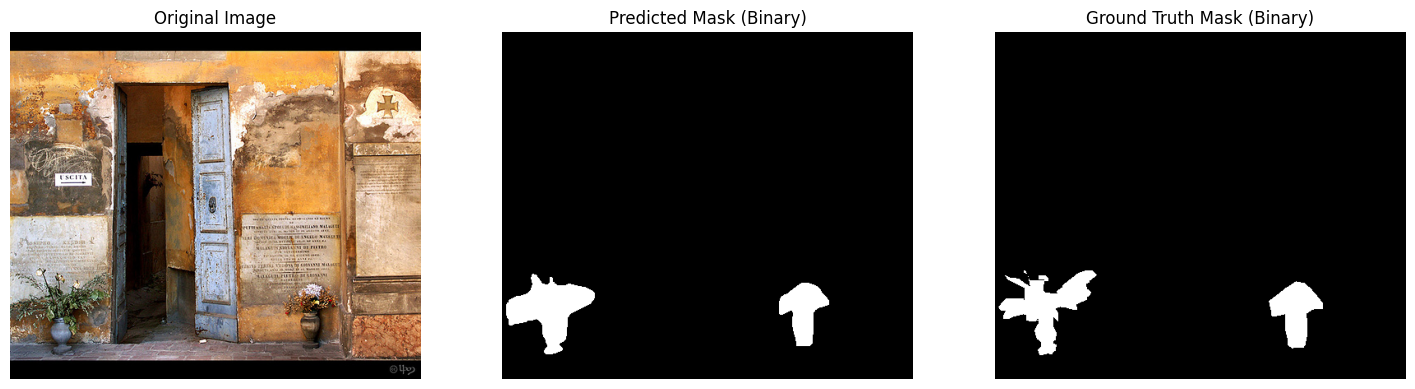

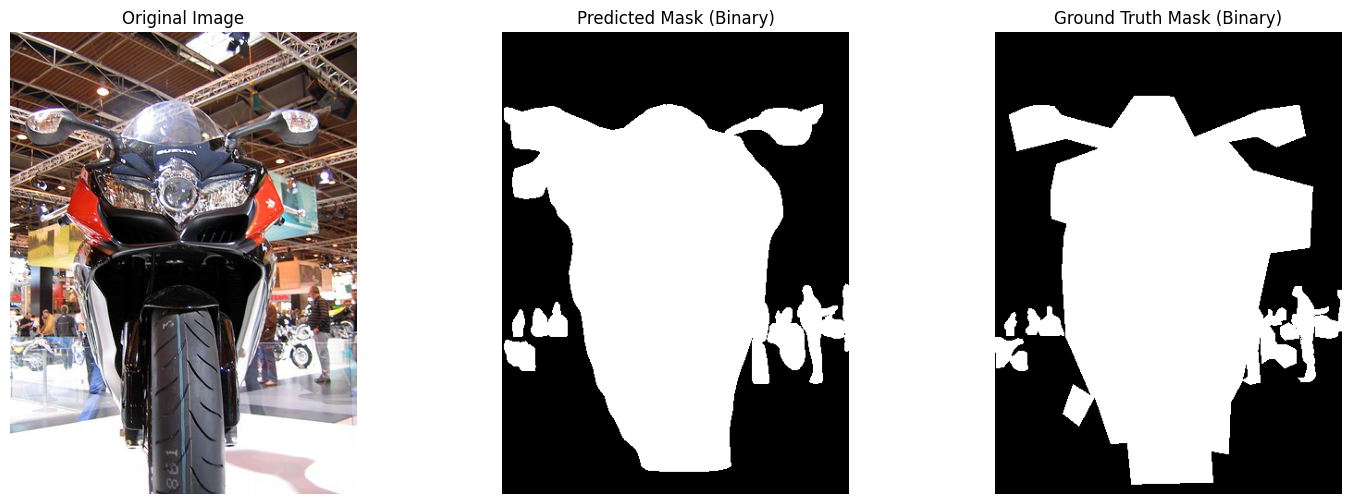

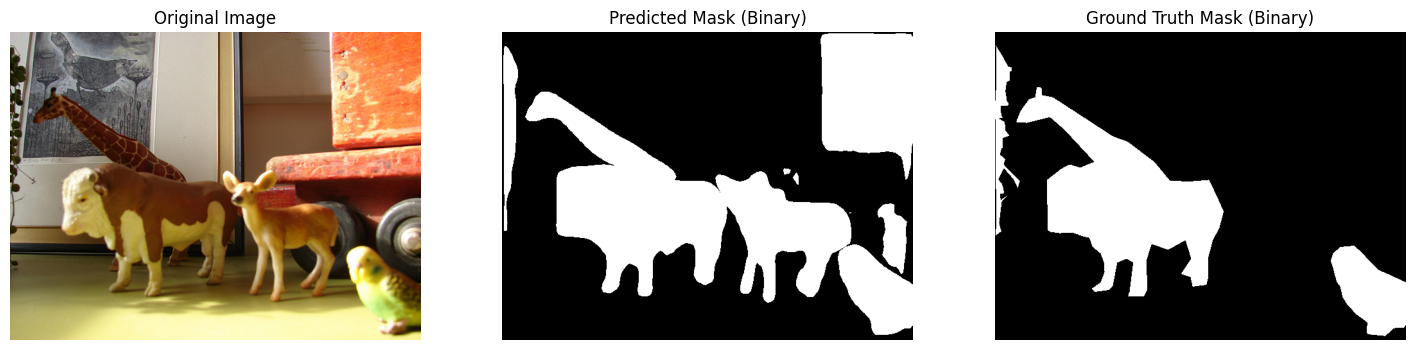

In [ ]:
# Evaluate after training
evaluate_binary_masks(model, dataset, device, score_threshold=0.5)

# Visualize predictions
visualize_binary_masks(model, dataset, device, num_images=3)
